# Data preprocessing and make a dataset

In [85]:
import os
import pandas as pd
import numpy as np
 


here = os.path.dirname(__file__) if "__file__" in locals() else "."

files = [("amazon", os.path.join(here, "./amazon_cells_labelled.txt")),
         ("imdb", os.path.join(here, "./imdb_labelled.txt")),
         ("yelp", os.path.join(here, "./yelp_labelled.txt"))]

#Initialize the data
raw_data = []
for provider, name in files:
    f = open(name,'r',encoding="utf-8")
    raw_data += f.readlines()
    
dfs = []             
for provider, name in files:
    df = pd.read_csv(name, sep="\t")
    df.columns = ["sentence", "emotion"]
    df["category_name"] = provider
    dfs.append(df)
    
data = pd.concat(dfs, axis=0)
data = data.sample(frac=1) #Shuffle the data
data.reset_index(drop=True,inplace=True) #Index reset
print(data.head())

x = pd.DataFrame(data)

                                            sentence  emotion category_name
0  Which is precisely why I am giving it such a b...        0          imdb
1                    The story line is just awful!          0          imdb
2            This place should honestly be blown up.        0          yelp
3           much better than the hard plastic cases.        1        amazon
4                           Best breakfast buffet!!!        1          yelp


In [86]:
# add emotion name 
def format_categories(target):
    """ format the labels """

    if(target=='amazon'):
        return '1'
    elif(target=='imdb'):
        return '2'
    else:
        return '3'

x['category'] = x.category_name.apply(lambda t: format_categories(t))

In [87]:
x

,sentence,emotion,category_name,category
0,Which is precisely why I am giving it such a b...,0,imdb,2
1,The story line is just awful!,0,imdb,2
2,This place should honestly be blown up.,0,yelp,3
3,much better than the hard plastic cases.,1,amazon,1
4,Best breakfast buffet!!!,1,yelp,3
...,...,...,...,...
2740,What a waste of money and time!.,0,amazon,1
2741,I miss it and wish they had one in Philadelphia!,1,yelp,3
2742,Punishment Park is a brilliant piece of cinema.,1,imdb,2
2743,"It didn't make me scared, horrified, or make m...",0,imdb,2


# Data Visualization

## Word cloud

In [88]:
#%pip install wordcloud

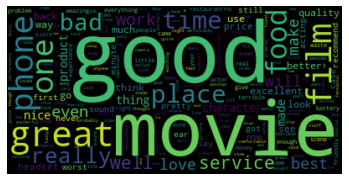

In [89]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


text = ''

for i in x.sentence:
    text += i
    
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [90]:
# nltk.download('stopwords')

## Word frequency in sentence

In [91]:
import nltk
import re
from nltk.probability import FreqDist
from nltk.corpus import stopwords

default_wt = nltk.word_tokenize
out = re.sub(r'[^\w\s]','',text)

words = default_wt(out) #filter punctuation

stop_words = set(stopwords.words('english')) # set English stop words

wordsFiltered = []

for w in words:
    if w not in stop_words:
        wordsFiltered.append(w)

fdist = FreqDist(wordsFiltered)
fdist.most_common(15)

ind = np.arange(len(fdist))
df = pd.DataFrame.from_dict(fdist, columns=['Counts'],orient='index')
df =df.sort_values(by=['Counts'],ascending=False)
# fdist

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

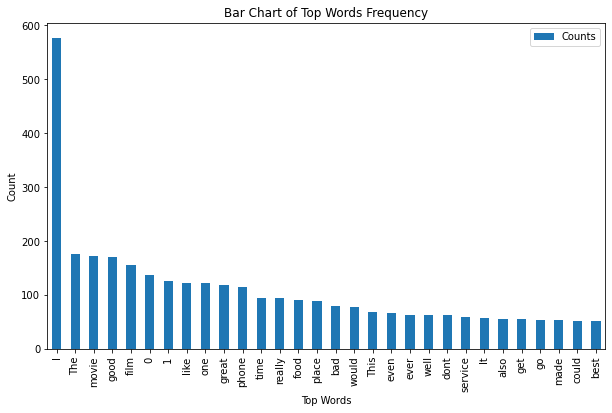

In [92]:
df[:30].plot(
    kind='bar',
    figsize=(10, 6),
    xlabel = "Top Words",
    ylabel = "Count",
    title = "Bar Chart of Top Words Frequency"
)



In [93]:
df

,Counts
I,576
The,176
movie,173
good,170
film,155
...,...
soul,1
Melville,1
Up,1
tremendous,1


# TF-IDF part

## Data cleaning

In [94]:
# text cleaning
from nltk.tokenize import word_tokenize
import numpy as np
import string
import warnings

warnings.filterwarnings("ignore")
i = 0
x['clean_sentence'] = ''
for row in x.sentence:
    # add spaces to prevent word merging
    row = row.replace('.', '. ', row.count('.')).replace(',', ', ', row.count(','))
    # split into words
    tokens = word_tokenize(row)
    # convert to lower case
    tokens = [token.lower() for token in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]
    # remove non-alphabetic or numeric tokens
    words = [word for word in words if word.isalnum()]
    # filter stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    x['clean_sentence'][i] = ' '.join(words)
    i += 1
x.clean_text = x.category_name + ' ' + x.clean_sentence
x.head()

,sentence,emotion,category_name,category,clean_sentence
0,Which is precisely why I am giving it such a b...,0,imdb,2,precisely giving bad review
1,The story line is just awful!,0,imdb,2,story line awful
2,This place should honestly be blown up.,0,yelp,3,place honestly blown
3,much better than the hard plastic cases.,1,amazon,1,much better hard plastic cases
4,Best breakfast buffet!!!,1,yelp,3,best breakfast buffet


## Implement TF-IDF

In [95]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# word-level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(x.clean_text)
x_tfidf = tfidf_vect.transform(x)
x_train_tfidf = tfidf_vect.transform(x_train)
x_test_tfidf = tfidf_vect.transform(x_test)


# ngram-level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2, 3), max_features=10000)
tfidf_vect_ngram.fit(x.clean_text) # measures bi-grams and tri-grams
x_tfidf_ngram = tfidf_vect_ngram.transform(x)
x_train_tfidf_ngram = tfidf_vect_ngram.transform(x_train)
x_test_tfidf_ngram = tfidf_vect_ngram.transform(x_test)

In [96]:
result = pd.DataFrame(x_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
ngram_result = pd.DataFrame(x_tfidf_ngram.toarray(), columns=tfidf_vect_ngram.get_feature_names())
print(result)

     0   00  010    1   10  100  1010   11  110   12  ...  yum  yummy  yun  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0    0.0  0.0   

     z  z500a  zero  zillion  zombie  zombiestudents  zombiez  
0  0.0    0.0   0.0      0.0     0.0             0.0      0.0  
1  0.0    0.0   0.0      0.0     0.0             0.0      0.0  
2  0.0    0.0   0.0      0.0     0.0             0.0      0.0  
3  0.0    0.0   0.0      0.0     0.0             0.0      0.0  
4  0.0    0.0   0.0      0.0     0.0             0.0      0.0  

[5 rows x 5122 columns]


# Naive Bayes Classifier part

## Dataset split

In [104]:
# split dataset
from sklearn import model_selection
from sklearn import preprocessing

# train-test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x.clean_text, x.emotion) 

# label encode the target 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

## Word Frequency vector

In [107]:
# count vector
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}') 
count_vect.fit(x.clean_text) # regexp selects tokens of 1 or more alphanumeric characters

xall_count = count_vect.transform(x.clean_text)
xtrain_count = count_vect.transform(x_train)
xtest_count = count_vect.transform(x_test)

In [108]:
pd.DataFrame(xall_count.toarray())

,0,1,2,3,4,5,6,7,8,9,...,5112,5113,5114,5115,5116,5117,5118,5119,5120,5121
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
x.clean_text

0                        imdb precisely giving bad review
1                                   imdb story line awful
2                               yelp place honestly blown
3                   amazon much better hard plastic cases
4                              yelp best breakfast buffet
                              ...                        
2740                              amazon waste money time
2741                      yelp miss wish one philadelphia
2742          imdb punishment park brilliant piece cinema
2743    imdb nt make scared horrified make sympathetic...
2744                          yelp service slow attentive
Length: 2745, dtype: object

In [110]:
# model wrapper function
from sklearn import metrics

def train_model(classifier, train_features, label, test_features):
    # fit the training data on classifier
    classifier.fit(train_features, label)
    
    # predict testing data labels
    predictions = classifier.predict(test_features)
    
    return metrics.accuracy_score(predictions, y_test)

# Naive Bayes
from sklearn import naive_bayes

# Count Vectors
nb_cv = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count)
print("[Naive Bayes] Word Frequency Vectors Accuracy:", round(nb_cv, 3))

# Word-Level TF-IDF Vectors
nb_wl = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print("[Naive Bayes] Word-Level TF-IDF Accuracy:", round(nb_wl, 3))

# Ngram-Level TF-IDF Vectors
nb_nl = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("[Naive Bayes] N-Gram-Level TF-IDF Accuracy:", round(nb_nl, 3))

[Naive Bayes] Word Frequency Vectors Accuracy: 0.782
[Naive Bayes] Word-Level TF-IDF Accuracy: 0.527
[Naive Bayes] N-Gram-Level TF-IDF Accuracy: 0.476


### We can find that the accuracy of word frequency vector is  better than tf-idf.
### In my opinion, it is because that the Count vectors contains all the word information in the document, but TF-IDF only contains the weight of the word.  However, the result may not be suitable for all sceneario, we have to choose the suitable way to predict by using domain knowledge.